# ME 5920 FINAL PROJECT - SCIENTIFIC SIMULATIONS GROUP 1



## Group Members



1.   George Ayobami Thomas
2.   Mridul Bhattarai
3.   Hossein Asgaribakhtiari




## 1.1. Setup and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Mounted at /content/drive


## 1.2. Load data from Google Drive (dataset 1)


In [ ]:
DATA_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TRAIN_FD001.xlsx'
df = pd.read_excel(DATA_PATH)

# Inspect
print(df.head())

   Engine_ID  Cy_F    OP_1    OP_2  OP_3     S_1     S_2      S_3      S_4  \
0          1     1 -0.0007 -0.0004   100  518.67  641.82  1589.70  1400.60   
1          1     2  0.0019 -0.0003   100  518.67  642.15  1591.82  1403.14   
2          1     3 -0.0043  0.0003   100  518.67  642.35  1587.99  1404.20   
3          1     4  0.0007  0.0000   100  518.67  642.35  1582.79  1401.87   
4          1     5 -0.0019 -0.0002   100  518.67  642.37  1582.85  1406.22   

     S_5  ...     S_14    S_15  S_16  S_17  S_18  S_19   S_20     S_21  \
0  14.62  ...  8138.62  8.4195  0.03   392  2388   100  39.06  23.4190   
1  14.62  ...  8131.49  8.4318  0.03   392  2388   100  39.00  23.4236   
2  14.62  ...  8133.23  8.4178  0.03   390  2388   100  38.95  23.3442   
3  14.62  ...  8133.83  8.3682  0.03   392  2388   100  38.88  23.3739   
4  14.62  ...  8133.80  8.4294  0.03   393  2388   100  38.90  23.4044   

   Unnamed: 26  RUL  
0          NaN  191  
1          NaN  190  
2          NaN  189 

## 1.3. Preprocessing and dataset definition


In [ ]:
FEATURE_COLS = ['OP_1', 'OP_2', 'OP_3'] + [f'S_{i}' for i in range(1, 22)]
TARGET_COL = 'RUL'
ID_COL = 'Engine_ID'
CYCLE_COL = 'Cy_F'

print(df[ID_COL].shape)

# Split engines into train/val
engine_ids = df[ID_COL].unique()
train_ids, val_ids = train_test_split(engine_ids, test_size=0.1, random_state=25)

(20631,)


## 1.4. Feature selection using correlation

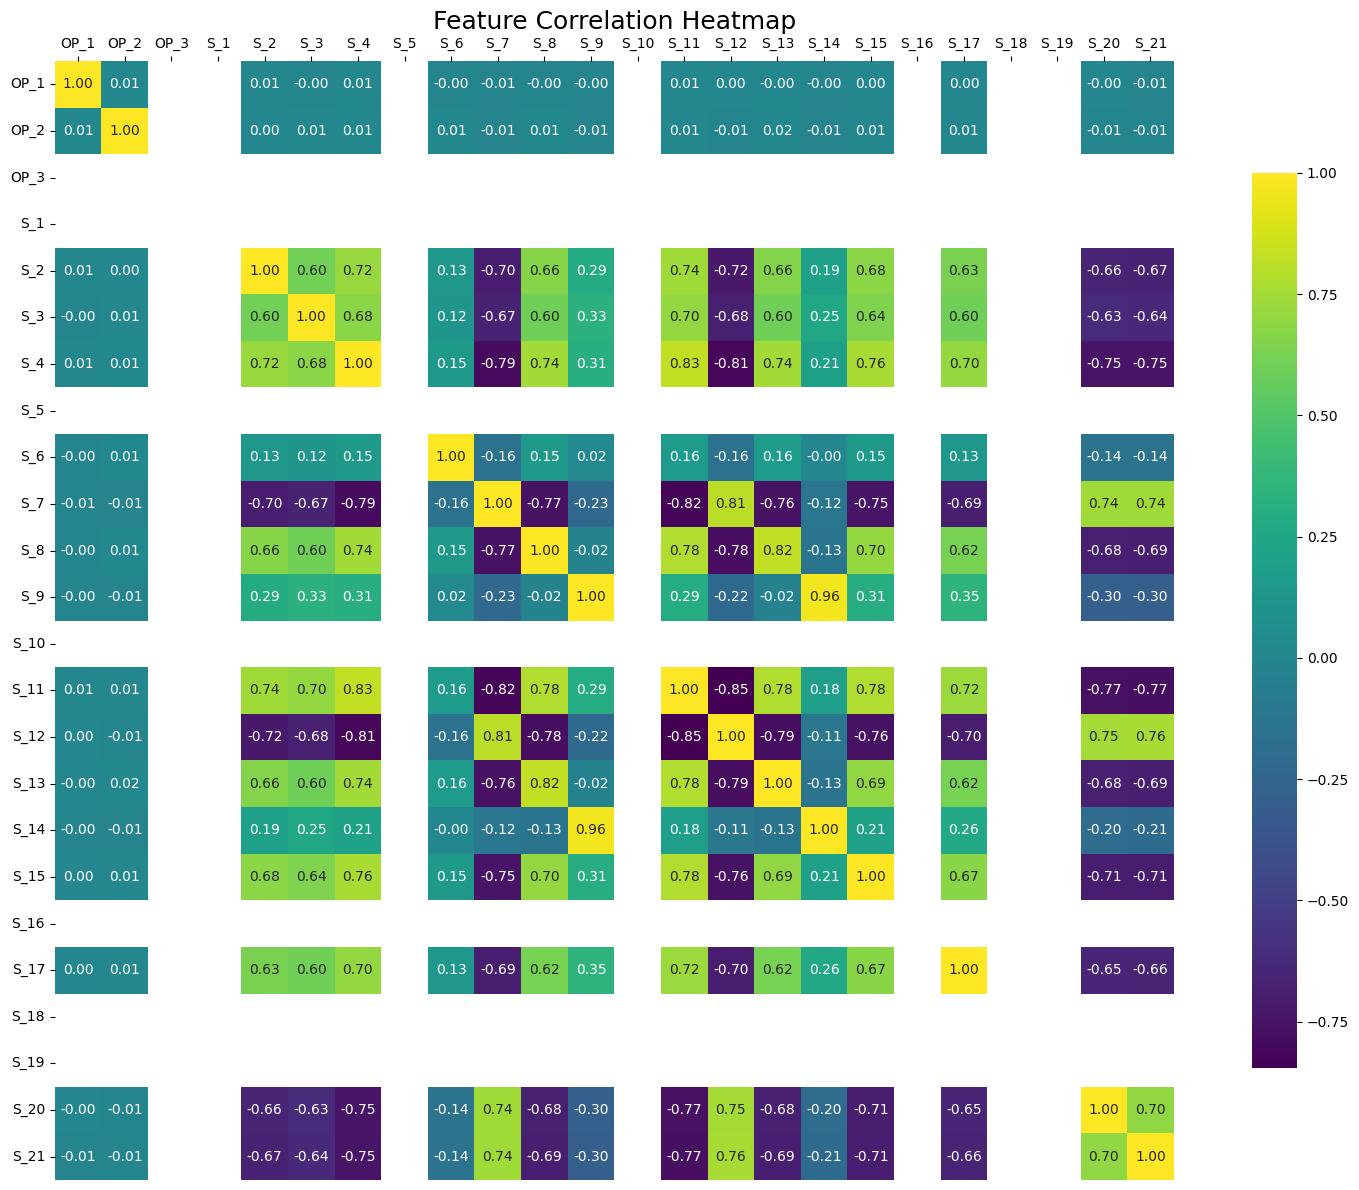

Removing 'S_14' due to high correlation (0.965) with 'S_9'
New Feature cols: 
 ['OP_1', 'OP_2', 'OP_3', 'S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_10', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_21']


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_train = df.loc[df[ID_COL].isin(train_ids), FEATURE_COLS]

# Compute correlation for alll the combination of two features
corr_matrix = X_train.corr()

# Plot
plt.figure(figsize=(16,12))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, cbar_kws={"shrink": .8})

# Title and ticks formatting
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.xaxis.set_ticks_position('top')# Move x-axis ticks to the top
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.show()


# Set to hold columns to drop
col_corr = set()

threshold = 0.95

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]

            if colname_i not in col_corr:
                print(f"Removing '{colname_i}' due to high correlation ({corr_matrix.iloc[i, j]:.3f}) with '{colname_j}'")
                col_corr.add(colname_i)
# New feature
New_Feature_Cols = [col for col in FEATURE_COLS if col not in col_corr]
print ("New Feature cols:","\n=================\n",New_Feature_Cols)

## 1.5. Drop the columns in 'train_corr' before applying scaling

In [ ]:
df_raw = df.copy() #dataframe with all the features
df_corr = df.copy() #dataframe with reduced featres
df_corr = df_corr.drop(columns=col_corr)

#Normalize features per column
scaler_raw=StandardScaler()
scaler_corr=StandardScaler()

df_raw[FEATURE_COLS]=scaler_raw.fit_transform(df_raw.loc[:,FEATURE_COLS])
df_corr[New_Feature_Cols] = scaler_corr.fit_transform(df_corr.loc[:, New_Feature_Cols])

# df[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])


from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler = StandardScaler()
train_ruls = df.loc[df[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1,1)
rul_scaler.fit(train_ruls)

# New column 'RUL_s' for the scaled targets
df_raw['RUL_s'] = df_raw[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

df_corr['RUL_s'] = df_corr[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

# Scale val targets (so loss is computed on same scale)
val_ruls_raw = df_raw.loc[df_raw[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_raw)

val_ruls_corr = df_corr.loc[df_corr[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_corr)
# Update target column name
TARGET_COL_S = 'RUL_s'


def make_sequences(Feature_Cols, df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[Feature_Cols].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

WINDOW_SIZE = 1

train_seqs_raw = make_sequences(FEATURE_COLS, df_raw, train_ids, WINDOW_SIZE)
val_seqs_raw   = make_sequences(FEATURE_COLS, df_raw, val_ids, WINDOW_SIZE)

train_seqs_corr = make_sequences(New_Feature_Cols, df_corr, train_ids, WINDOW_SIZE)
val_seqs_corr  = make_sequences(New_Feature_Cols, df_corr, val_ids, WINDOW_SIZE)

class SequenceDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        x, y = self.seqs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_ds_raw = SequenceDataset(train_seqs_raw)
val_ds_raw   = SequenceDataset(val_seqs_raw)

train_loader_raw = DataLoader(train_ds_raw, batch_size=64, shuffle=False)
val_loader_raw   = DataLoader(val_ds_raw, batch_size=64)


train_ds_corr = SequenceDataset(train_seqs_corr)
val_ds_corr  = SequenceDataset(val_seqs_corr)

train_loader_corr = DataLoader(train_ds_corr, batch_size=64, shuffle=False)
val_loader_corr   = DataLoader(val_ds_corr, batch_size=64)

## 2.1. LSTM model definition

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last).squeeze()

## 2.2. Transformer model definition

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_enc  = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out      = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        last = x[:, -1, :]
        return self.fc_out(last).squeeze()

## 2.3. Fully Connected Neural Network (FCNN) definition

In [ ]:
class FCRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

## 2.2.1. Flattened dataset for FCNN

In [ ]:
class FlattenedDataset(Dataset):
    def __init__(self, seqs):
        self.x = [torch.tensor(s[0].flatten(), dtype=torch.float32) for s in seqs]
        self.y = [torch.tensor(s[1], dtype=torch.float32) for s in seqs]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

flat_train_ds_raw = FlattenedDataset(train_seqs_raw)
flat_val_ds_raw   = FlattenedDataset(val_seqs_raw)

flat_train_loader_raw = DataLoader(flat_train_ds_raw, batch_size=64)
flat_val_loader_raw   = DataLoader(flat_val_ds_raw, batch_size=64)

flat_train_ds_corr = FlattenedDataset(train_seqs_corr)
flat_val_ds_corr   = FlattenedDataset(val_seqs_corr)

flat_train_loader_corr = DataLoader(flat_train_ds_corr, batch_size=64)
flat_val_loader_corr   = DataLoader(flat_val_ds_corr, batch_size=64)

## 2.4. Convolutional Neural Network (CNN) regression model

In [ ]:
class CNNRegressor(nn.Module):
    def __init__(self, num_features, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        # x: [batch, window_size, features]
        x = x.permute(0, 2, 1)  # → [batch, features, window]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # → [batch, 64]
        return self.fc(x).squeeze(-1)  # → [batch]

## 3. Training and evaluation functions

In [ ]:
def train_epoch(model, loader, optim, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optim.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

## 4.1. Running LSTM


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm   = LSTMRegressor(input_dim=len(FEATURE_COLS), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm, train_loader_raw, opt_lstm, crit, device)
    val_loss   = eval_model(lstm, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.4883, Val MSE=0.3205
Epoch 2: LSTM Train MSE=0.4017, Val MSE=0.3222
Epoch 3: LSTM Train MSE=0.3919, Val MSE=0.3248
Epoch 4: LSTM Train MSE=0.3871, Val MSE=0.3268
Epoch 5: LSTM Train MSE=0.3836, Val MSE=0.3286
Epoch 6: LSTM Train MSE=0.3810, Val MSE=0.3302
Epoch 7: LSTM Train MSE=0.3790, Val MSE=0.3316
Epoch 8: LSTM Train MSE=0.3773, Val MSE=0.3325
Epoch 9: LSTM Train MSE=0.3759, Val MSE=0.3333
Epoch 10: LSTM Train MSE=0.3747, Val MSE=0.3338
Epoch 11: LSTM Train MSE=0.3736, Val MSE=0.3340
Epoch 12: LSTM Train MSE=0.3727, Val MSE=0.3345
Epoch 13: LSTM Train MSE=0.3719, Val MSE=0.3346
Epoch 14: LSTM Train MSE=0.3710, Val MSE=0.3344
Epoch 15: LSTM Train MSE=0.3705, Val MSE=0.3348
Epoch 16: LSTM Train MSE=0.3698, Val MSE=0.3344
Epoch 17: LSTM Train MSE=0.3691, Val MSE=0.3341
Epoch 18: LSTM Train MSE=0.3686, Val MSE=0.3342
Epoch 19: LSTM Train MSE=0.3682, Val MSE=0.3344
Epoch 20: LSTM Train MSE=0.3677, Val MSE=0.3346
Epoch 21: LSTM Train MSE=0.3673, Val MSE=0.3346
E

## 4.2. Running Transformer


In [ ]:
trans   = TransformerRegressor(input_dim=len(FEATURE_COLS), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans, train_loader_raw, opt_trans, crit, device)
    val_loss   = eval_model(trans, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=0.6764, Val MSE=0.4425
Epoch 2: Trans Train MSE=0.4952, Val MSE=0.4566
Epoch 3: Trans Train MSE=0.4585, Val MSE=0.4707
Epoch 4: Trans Train MSE=0.4485, Val MSE=0.4399
Epoch 5: Trans Train MSE=0.4369, Val MSE=0.4062
Epoch 6: Trans Train MSE=0.4251, Val MSE=0.3937
Epoch 7: Trans Train MSE=0.4201, Val MSE=0.3759
Epoch 8: Trans Train MSE=0.4169, Val MSE=0.3630
Epoch 9: Trans Train MSE=0.4092, Val MSE=0.3573
Epoch 10: Trans Train MSE=0.4059, Val MSE=0.3531
Epoch 11: Trans Train MSE=0.4046, Val MSE=0.3554
Epoch 12: Trans Train MSE=0.4002, Val MSE=0.3402
Epoch 13: Trans Train MSE=0.4001, Val MSE=0.3510
Epoch 14: Trans Train MSE=0.3951, Val MSE=0.3359
Epoch 15: Trans Train MSE=0.3974, Val MSE=0.3414
Epoch 16: Trans Train MSE=0.3944, Val MSE=0.3406
Epoch 17: Trans Train MSE=0.3978, Val MSE=0.3403
Epoch 18: Trans Train MSE=0.4050, Val MSE=0.3461
Epoch 19: Trans Train MSE=0.3955, Val MSE=0.3463
Epoch 20: Trans Train MSE=0.3977, Val MSE=0.3360
Epoch 21: Trans Train MSE=0.3

## 4.3. Running FCNN


In [ ]:
fcnn = FCRegressor(input_dim=len(FEATURE_COLS) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn, flat_train_loader_raw, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn, flat_val_loader_raw, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.4770, Val MSE=0.3467
Epoch 2: FCNN Train MSE=0.4060, Val MSE=0.3354
Epoch 3: FCNN Train MSE=0.3955, Val MSE=0.3350
Epoch 4: FCNN Train MSE=0.3908, Val MSE=0.3352
Epoch 5: FCNN Train MSE=0.3872, Val MSE=0.3368
Epoch 6: FCNN Train MSE=0.3843, Val MSE=0.3374
Epoch 7: FCNN Train MSE=0.3823, Val MSE=0.3376
Epoch 8: FCNN Train MSE=0.3806, Val MSE=0.3376
Epoch 9: FCNN Train MSE=0.3791, Val MSE=0.3376
Epoch 10: FCNN Train MSE=0.3777, Val MSE=0.3374
Epoch 11: FCNN Train MSE=0.3764, Val MSE=0.3369
Epoch 12: FCNN Train MSE=0.3754, Val MSE=0.3365
Epoch 13: FCNN Train MSE=0.3744, Val MSE=0.3362
Epoch 14: FCNN Train MSE=0.3737, Val MSE=0.3359
Epoch 15: FCNN Train MSE=0.3735, Val MSE=0.3340
Epoch 16: FCNN Train MSE=0.3716, Val MSE=0.3358
Epoch 17: FCNN Train MSE=0.3711, Val MSE=0.3358
Epoch 18: FCNN Train MSE=0.3705, Val MSE=0.3359
Epoch 19: FCNN Train MSE=0.3698, Val MSE=0.3356
Epoch 20: FCNN Train MSE=0.3693, Val MSE=0.3353
Epoch 21: FCNN Train MSE=0.3686, Val MSE=0.3356
E

## 4.4. Running CNN

In [ ]:
cnn_model = CNNRegressor(num_features=len(FEATURE_COLS), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)



for epoch in range(1, 101):
    cnn_model.train()
    total_loss = 0
    for xb, yb in train_loader_raw:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_raw.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_raw:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_raw.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.5137, Val Loss=0.3297
Epoch 2: CNN Train Loss=0.4029, Val Loss=0.3360
Epoch 3: CNN Train Loss=0.3910, Val Loss=0.3395
Epoch 4: CNN Train Loss=0.3866, Val Loss=0.3408
Epoch 5: CNN Train Loss=0.3840, Val Loss=0.3409
Epoch 6: CNN Train Loss=0.3822, Val Loss=0.3410
Epoch 7: CNN Train Loss=0.3808, Val Loss=0.3410
Epoch 8: CNN Train Loss=0.3796, Val Loss=0.3411
Epoch 9: CNN Train Loss=0.3785, Val Loss=0.3409
Epoch 10: CNN Train Loss=0.3775, Val Loss=0.3409
Epoch 11: CNN Train Loss=0.3766, Val Loss=0.3405
Epoch 12: CNN Train Loss=0.3757, Val Loss=0.3401
Epoch 13: CNN Train Loss=0.3748, Val Loss=0.3397
Epoch 14: CNN Train Loss=0.3740, Val Loss=0.3393
Epoch 15: CNN Train Loss=0.3731, Val Loss=0.3387
Epoch 16: CNN Train Loss=0.3723, Val Loss=0.3383
Epoch 17: CNN Train Loss=0.3715, Val Loss=0.3379
Epoch 18: CNN Train Loss=0.3707, Val Loss=0.3375
Epoch 19: CNN Train Loss=0.3700, Val Loss=0.3371
Epoch 20: CNN Train Loss=0.3693, Val Loss=0.3369
Epoch 21: CNN Train Loss=0.36

## 5. Compare final validation losses

In [ ]:
lstm_val  = eval_model(lstm, train_loader_raw, crit, device)
trans_val = eval_model(trans, train_loader_raw, crit, device)
fcnn_val  = eval_model(fcnn, flat_train_loader_raw, crit, device)
cnn_val   = eval_model(cnn_model, train_loader_raw, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3432, Transformer: 0.3394, FCNN: 0.2964, CNN: 0.3437


## 6. Load test data and run inference

In [ ]:
import matplotlib.pyplot as plt

TEST_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TEST_FD001.xlsx'
test_df   = pd.read_excel(TEST_PATH)

test_df_raw=test_df.copy()

# Remove columns that are in the col_corr set
test_df_corr=test_df.copy()
test_df_corr = test_df_corr.drop(columns=col_corr, errors='ignore')
test_df_corr.reset_index(drop=True, inplace=True)

# Apply same scaling
# test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS])
test_df_raw[FEATURE_COLS] = scaler_raw.transform(test_df_raw.loc[:, FEATURE_COLS])
test_df_raw[TARGET_COL_S] = rul_scaler.transform(test_df_raw[[TARGET_COL]])

test_df_corr[New_Feature_Cols] = scaler_corr.transform(test_df_corr.loc[:, New_Feature_Cols])
test_df_corr[TARGET_COL_S] = rul_scaler.transform(test_df_corr[[TARGET_COL]])

def make_test_sequences(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[FEATURE_COLS].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm(x_win).item())
                preds_t.append(trans(x_win).item())
                preds_f.append(fcnn(x_win).item())
                preds_c.append(cnn_model(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences(test_df_raw, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#7. Plot and save for a chosen engine

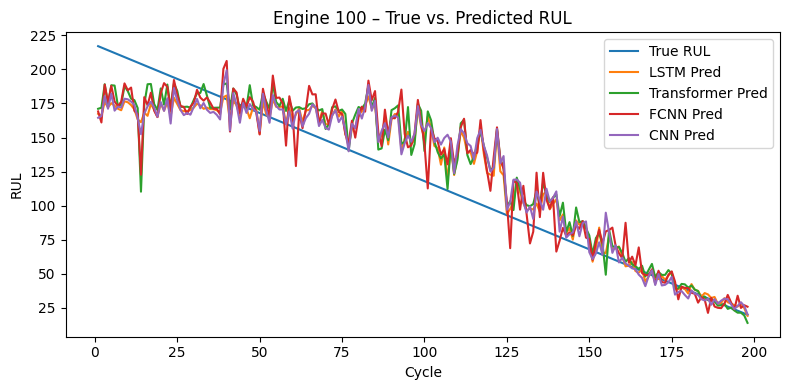

In [ ]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()

## 8.1. Running LSTM using new feature columns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_corr   = LSTMRegressor(input_dim=len(New_Feature_Cols), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_corr.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_corr, train_loader_corr, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.4930, Val MSE=0.3242
Epoch 2: LSTM Train MSE=0.4135, Val MSE=0.3197
Epoch 3: LSTM Train MSE=0.4011, Val MSE=0.3226
Epoch 4: LSTM Train MSE=0.3954, Val MSE=0.3250
Epoch 5: LSTM Train MSE=0.3913, Val MSE=0.3268
Epoch 6: LSTM Train MSE=0.3880, Val MSE=0.3283
Epoch 7: LSTM Train MSE=0.3854, Val MSE=0.3297
Epoch 8: LSTM Train MSE=0.3834, Val MSE=0.3308
Epoch 9: LSTM Train MSE=0.3817, Val MSE=0.3318
Epoch 10: LSTM Train MSE=0.3804, Val MSE=0.3325
Epoch 11: LSTM Train MSE=0.3792, Val MSE=0.3330
Epoch 12: LSTM Train MSE=0.3783, Val MSE=0.3334
Epoch 13: LSTM Train MSE=0.3774, Val MSE=0.3340
Epoch 14: LSTM Train MSE=0.3769, Val MSE=0.3343
Epoch 15: LSTM Train MSE=0.3761, Val MSE=0.3344
Epoch 16: LSTM Train MSE=0.3756, Val MSE=0.3344
Epoch 17: LSTM Train MSE=0.3751, Val MSE=0.3344
Epoch 18: LSTM Train MSE=0.3745, Val MSE=0.3343
Epoch 19: LSTM Train MSE=0.3740, Val MSE=0.3342
Epoch 20: LSTM Train MSE=0.3736, Val MSE=0.3343
Epoch 21: LSTM Train MSE=0.3732, Val MSE=0.3345
E

## 8.2. Running Transformer using new feature columns

In [ ]:
trans_corr   = TransformerRegressor(input_dim=len(New_Feature_Cols), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_corr, train_loader_corr, opt_trans, crit, device)
    val_loss   = eval_model(trans_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=0.6413, Val MSE=0.4954
Epoch 2: Trans Train MSE=0.4785, Val MSE=0.4703
Epoch 3: Trans Train MSE=0.4649, Val MSE=0.4377
Epoch 4: Trans Train MSE=0.4489, Val MSE=0.4114
Epoch 5: Trans Train MSE=0.4379, Val MSE=0.3976
Epoch 6: Trans Train MSE=0.4333, Val MSE=0.3782
Epoch 7: Trans Train MSE=0.4224, Val MSE=0.3630
Epoch 8: Trans Train MSE=0.4173, Val MSE=0.3623
Epoch 9: Trans Train MSE=0.4144, Val MSE=0.3540
Epoch 10: Trans Train MSE=0.4129, Val MSE=0.3579
Epoch 11: Trans Train MSE=0.4109, Val MSE=0.3518
Epoch 12: Trans Train MSE=0.4079, Val MSE=0.3524
Epoch 13: Trans Train MSE=0.4074, Val MSE=0.3448
Epoch 14: Trans Train MSE=0.4070, Val MSE=0.3462
Epoch 15: Trans Train MSE=0.4072, Val MSE=0.3432
Epoch 16: Trans Train MSE=0.4059, Val MSE=0.3495
Epoch 17: Trans Train MSE=0.4025, Val MSE=0.3420
Epoch 18: Trans Train MSE=0.4057, Val MSE=0.3476
Epoch 19: Trans Train MSE=0.4050, Val MSE=0.3450
Epoch 20: Trans Train MSE=0.4054, Val MSE=0.3474
Epoch 21: Trans Train MSE=0.4

## 8.3. Running FCNN using new feature columns

In [ ]:
fcnn_corr = FCRegressor(input_dim=len(New_Feature_Cols) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_corr, flat_train_loader_corr, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_corr, flat_val_loader_corr, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.4835, Val MSE=0.3695
Epoch 2: FCNN Train MSE=0.4164, Val MSE=0.3428
Epoch 3: FCNN Train MSE=0.4051, Val MSE=0.3381
Epoch 4: FCNN Train MSE=0.3987, Val MSE=0.3341
Epoch 5: FCNN Train MSE=0.3944, Val MSE=0.3358
Epoch 6: FCNN Train MSE=0.3912, Val MSE=0.3348
Epoch 7: FCNN Train MSE=0.3885, Val MSE=0.3341
Epoch 8: FCNN Train MSE=0.3865, Val MSE=0.3338
Epoch 9: FCNN Train MSE=0.3850, Val MSE=0.3329
Epoch 10: FCNN Train MSE=0.3833, Val MSE=0.3330
Epoch 11: FCNN Train MSE=0.3820, Val MSE=0.3330
Epoch 12: FCNN Train MSE=0.3807, Val MSE=0.3329
Epoch 13: FCNN Train MSE=0.3799, Val MSE=0.3308
Epoch 14: FCNN Train MSE=0.3787, Val MSE=0.3338
Epoch 15: FCNN Train MSE=0.3777, Val MSE=0.3340
Epoch 16: FCNN Train MSE=0.3768, Val MSE=0.3335
Epoch 17: FCNN Train MSE=0.3760, Val MSE=0.3342
Epoch 18: FCNN Train MSE=0.3752, Val MSE=0.3343
Epoch 19: FCNN Train MSE=0.3746, Val MSE=0.3348
Epoch 20: FCNN Train MSE=0.3737, Val MSE=0.3346
Epoch 21: FCNN Train MSE=0.3732, Val MSE=0.3348
E

## 8.4. Running CNN using new feature columns

In [ ]:
cnn_model_corr = CNNRegressor(num_features=len(New_Feature_Cols), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_corr.parameters(), lr=1e-3, weight_decay=1e-5)



for epoch in range(1, 101):
    cnn_model_corr.train()
    total_loss = 0
    for xb, yb in train_loader_corr:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_corr(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_corr.dataset)

    # Validation
    cnn_model_corr.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_corr:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_corr(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_corr.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.5388, Val Loss=0.3435
Epoch 2: CNN Train Loss=0.4250, Val Loss=0.3296
Epoch 3: CNN Train Loss=0.4029, Val Loss=0.3346
Epoch 4: CNN Train Loss=0.3930, Val Loss=0.3363
Epoch 5: CNN Train Loss=0.3874, Val Loss=0.3352
Epoch 6: CNN Train Loss=0.3844, Val Loss=0.3344
Epoch 7: CNN Train Loss=0.3823, Val Loss=0.3335
Epoch 8: CNN Train Loss=0.3805, Val Loss=0.3331
Epoch 9: CNN Train Loss=0.3792, Val Loss=0.3328
Epoch 10: CNN Train Loss=0.3781, Val Loss=0.3324
Epoch 11: CNN Train Loss=0.3771, Val Loss=0.3323
Epoch 12: CNN Train Loss=0.3762, Val Loss=0.3322
Epoch 13: CNN Train Loss=0.3755, Val Loss=0.3324
Epoch 14: CNN Train Loss=0.3748, Val Loss=0.3325
Epoch 15: CNN Train Loss=0.3742, Val Loss=0.3326
Epoch 16: CNN Train Loss=0.3736, Val Loss=0.3326
Epoch 17: CNN Train Loss=0.3731, Val Loss=0.3325
Epoch 18: CNN Train Loss=0.3725, Val Loss=0.3325
Epoch 19: CNN Train Loss=0.3721, Val Loss=0.3327
Epoch 20: CNN Train Loss=0.3717, Val Loss=0.3326
Epoch 21: CNN Train Loss=0.37

## 9. Comparing final validation losses for new feature columns

In [ ]:
lstm_val  = eval_model(lstm_corr, train_loader_corr, crit, device)
trans_val = eval_model(trans_corr, train_loader_corr, crit, device)
fcnn_val  = eval_model(fcnn_corr, flat_train_loader_corr, crit, device)
cnn_val   = eval_model(cnn_model_corr, train_loader_corr, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3468, Transformer: 0.3591, FCNN: 0.2830, CNN: 0.3496


## 10. Load test data and run inference for new feature columns

In [ ]:
def make_test_sequences_corr(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[New_Feature_Cols].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_corr(x_win).item())
                preds_t.append(trans_corr(x_win).item())
                preds_f.append(fcnn_corr(x_win).item())
                preds_c.append(cnn_model_corr(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs_corr = make_test_sequences_corr(test_df_corr, WINDOW_SIZE)

## 11.1. Plot for a chosen engine using new feature columns

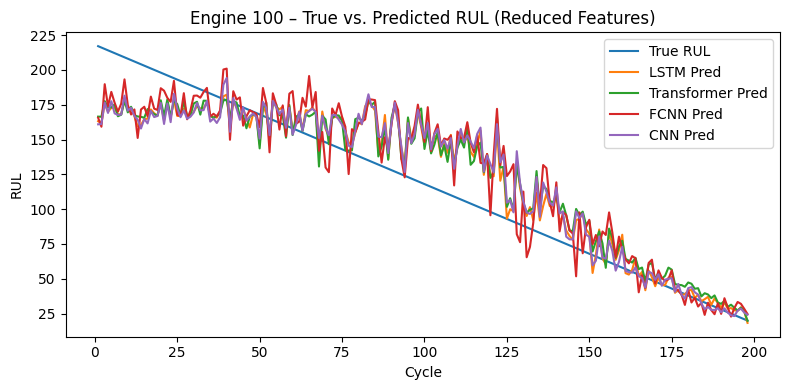

In [ ]:
engine_id_corr = list(test_seqs_corr.keys())[99]  # change as desired
seq_corr       = test_seqs_corr[engine_id_corr]


true_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq_corr['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq_corr['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq_corr['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq_corr['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq_corr['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq_corr['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq_corr['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id_corr} – True vs. Predicted RUL (Reduced Features)')
plt.legend()
plt.tight_layout()
plt.show()

## 12. PCA whitening

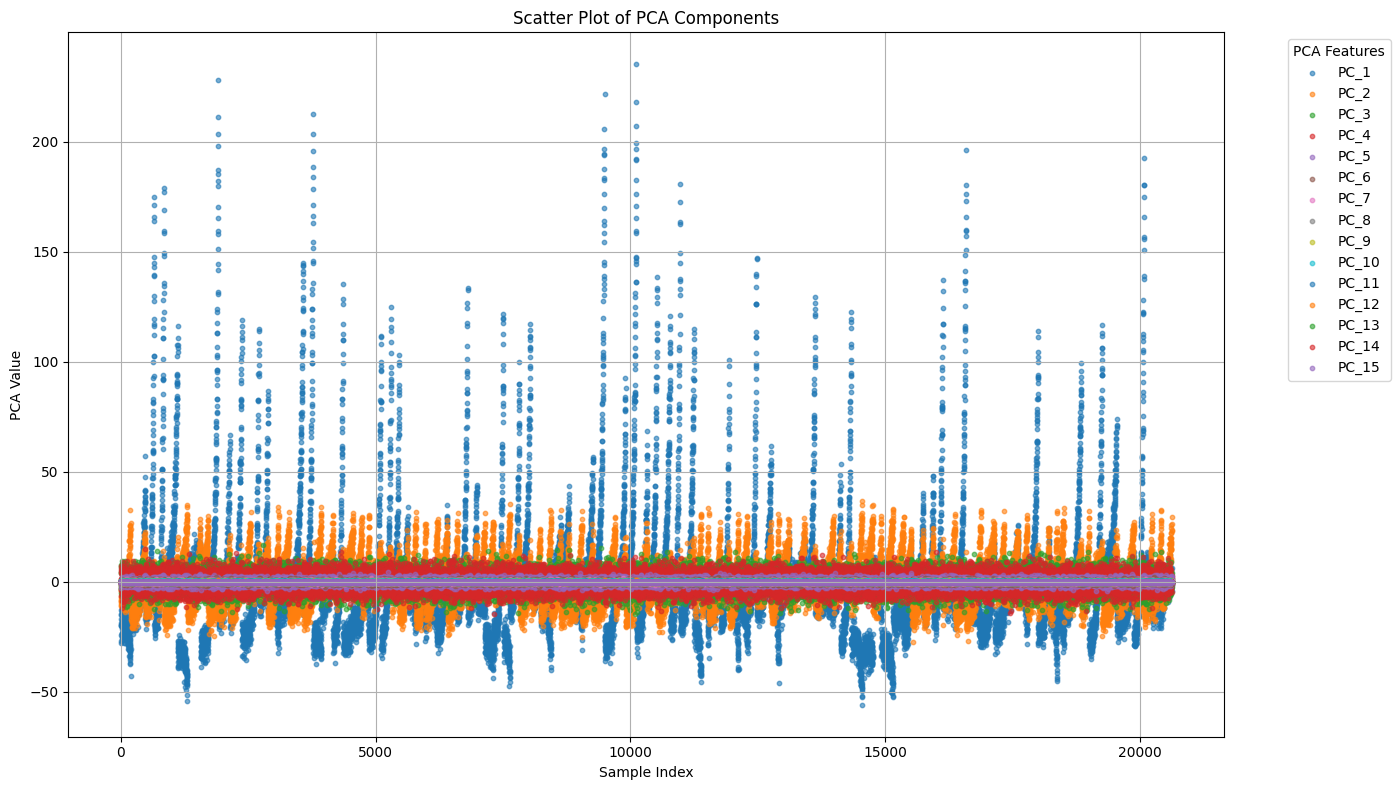

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% variance
pca = PCA(n_components=15)
pca_features = pca.fit_transform(df[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_features, columns=feature_cols_pca, index=df.index)

# Optional: downsample if too large
df_pca_plot_sample = df_pca.sample(n=20000, random_state=42) if len(df_pca) > 20000 else df_pca

# Create a scatter plot of all PCA components
plt.figure(figsize=(14, 8))

# Plot each PCA component in a different color
for i, col in enumerate(df_pca.columns):
    plt.scatter(df_pca_plot_sample.index, df_pca_plot_sample[col],
                label=col, s=10, alpha=0.6)

plt.title("Scatter Plot of PCA Components")
plt.xlabel("Sample Index")
plt.ylabel("PCA Value")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), title="PCA Features")
plt.grid(True)
plt.tight_layout()
plt.show()

## 12.1. Create a copy of df for PCA transformation

In [ ]:
df_pca_applied = df.copy()

# Drop original feature columns from the copy
df_pca_applied.drop(columns=FEATURE_COLS, inplace=True)

# Add PCA-transformed features to the copy
df_pca_applied = pd.concat([df_pca_applied, df_pca], axis=1)


from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler_pca = StandardScaler()
train_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1, 1)
rul_scaler_pca.fit(train_ruls_pca)

# New column 'RUL_s' for the scaled targets
df_pca_applied['RUL_s'] = df_pca_applied[TARGET_COL].astype(np.float64).values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls_pca)

# Scale val targets (so loss is computed on same scale)
val_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_pca)

print(df_pca_applied.head)

<bound method NDFrame.head of        Engine_ID  Cy_F  Unnamed: 26  RUL       PC_1       PC_2      PC_3  \
0              1     1          NaN  191 -18.534956  -7.276926  3.888731   
1              1     2          NaN  190 -24.367088  -2.678869  4.474825   
2              1     3          NaN  189 -16.747614  -3.867730  0.309449   
3              1     4          NaN  188 -19.500249  -8.357856 -2.991525   
4              1     5          NaN  187 -14.820892  -4.261560 -5.236373   
...          ...   ...          ...  ...        ...        ...       ...   
20626        100   196          NaN    4  -1.403228  22.136422 -3.028443   
20627        100   197          NaN    3  -1.572367  29.408176  0.309580   
20628        100   198          NaN    2   1.390626  23.235463  1.165958   
20629        100   199          NaN    1   6.149880  23.545672  4.085213   
20630        100   200          NaN    0  -4.162033  26.100663 -2.460406   

           PC_4      PC_5      PC_6      PC_7      PC_8  

## 12.2.

In [ ]:
def make_sequences_pca(df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[feature_cols_pca].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

##12.3.

In [ ]:
WINDOW_SIZE = 1

train_seqs_pca = make_sequences_pca(df_pca_applied, train_ids, WINDOW_SIZE)
val_seqs_pca   = make_sequences_pca(df_pca_applied, val_ids, WINDOW_SIZE)

train_ds_pca = SequenceDataset(train_seqs_pca)
val_ds_pca   = SequenceDataset(val_seqs_pca)

train_loader_pca = DataLoader(train_ds_pca, batch_size=64, shuffle=False)
val_loader_pca   = DataLoader(val_ds_pca, batch_size=64)

##12.4.

In [ ]:
flat_train_ds_pca = FlattenedDataset(train_seqs_pca)
flat_val_ds_pca   = FlattenedDataset(val_seqs_pca)

flat_train_loader_pca = DataLoader(flat_train_ds_pca, batch_size=64)
flat_val_loader_pca   = DataLoader(flat_val_ds_pca, batch_size=64)

## 13.1. Running LSTM for PCA-whitened data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pca   = LSTMRegressor(input_dim=len(feature_cols_pca), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_pca.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_pca, train_loader_pca, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.4978, Val MSE=0.3678
Epoch 2: LSTM Train MSE=0.4026, Val MSE=0.3654
Epoch 3: LSTM Train MSE=0.3926, Val MSE=0.3646
Epoch 4: LSTM Train MSE=0.3878, Val MSE=0.3633
Epoch 5: LSTM Train MSE=0.3846, Val MSE=0.3619
Epoch 6: LSTM Train MSE=0.3822, Val MSE=0.3605
Epoch 7: LSTM Train MSE=0.3803, Val MSE=0.3591
Epoch 8: LSTM Train MSE=0.3787, Val MSE=0.3578
Epoch 9: LSTM Train MSE=0.3774, Val MSE=0.3566
Epoch 10: LSTM Train MSE=0.3762, Val MSE=0.3555
Epoch 11: LSTM Train MSE=0.3753, Val MSE=0.3545
Epoch 12: LSTM Train MSE=0.3745, Val MSE=0.3537
Epoch 13: LSTM Train MSE=0.3735, Val MSE=0.3528
Epoch 14: LSTM Train MSE=0.3728, Val MSE=0.3520
Epoch 15: LSTM Train MSE=0.3723, Val MSE=0.3515
Epoch 16: LSTM Train MSE=0.3716, Val MSE=0.3507
Epoch 17: LSTM Train MSE=0.3710, Val MSE=0.3499
Epoch 18: LSTM Train MSE=0.3704, Val MSE=0.3493
Epoch 19: LSTM Train MSE=0.3699, Val MSE=0.3488
Epoch 20: LSTM Train MSE=0.3696, Val MSE=0.3483
Epoch 21: LSTM Train MSE=0.3690, Val MSE=0.3476
E

## 13.2. Running Transformer for PCA-whitened data

In [ ]:
trans_pca   = TransformerRegressor(input_dim=len(feature_cols_pca), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_pca, train_loader_pca, opt_trans, crit, device)
    val_loss   = eval_model(trans_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=0.6912, Val MSE=0.4493
Epoch 2: Trans Train MSE=0.5144, Val MSE=0.4417
Epoch 3: Trans Train MSE=0.4769, Val MSE=0.4348
Epoch 4: Trans Train MSE=0.4625, Val MSE=0.4380
Epoch 5: Trans Train MSE=0.4545, Val MSE=0.4302
Epoch 6: Trans Train MSE=0.4491, Val MSE=0.4277
Epoch 7: Trans Train MSE=0.4406, Val MSE=0.4142
Epoch 8: Trans Train MSE=0.4382, Val MSE=0.4204
Epoch 9: Trans Train MSE=0.4340, Val MSE=0.4042
Epoch 10: Trans Train MSE=0.4289, Val MSE=0.3954
Epoch 11: Trans Train MSE=0.4221, Val MSE=0.3886
Epoch 12: Trans Train MSE=0.4230, Val MSE=0.3850
Epoch 13: Trans Train MSE=0.4217, Val MSE=0.3850
Epoch 14: Trans Train MSE=0.4152, Val MSE=0.3689
Epoch 15: Trans Train MSE=0.4141, Val MSE=0.3715
Epoch 16: Trans Train MSE=0.4110, Val MSE=0.3716
Epoch 17: Trans Train MSE=0.4128, Val MSE=0.3715
Epoch 18: Trans Train MSE=0.4109, Val MSE=0.3636
Epoch 19: Trans Train MSE=0.4089, Val MSE=0.3652
Epoch 20: Trans Train MSE=0.4111, Val MSE=0.3581
Epoch 21: Trans Train MSE=0.4

## 13.3. Running FCNN for PCA-whitened data

In [ ]:
fcnn_pca = FCRegressor(input_dim=len(feature_cols_pca) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_pca, flat_train_loader_pca, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_pca, flat_val_loader_pca, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.9215, Val MSE=0.6604
Epoch 2: FCNN Train MSE=0.4531, Val MSE=0.3872
Epoch 3: FCNN Train MSE=0.4238, Val MSE=0.3849
Epoch 4: FCNN Train MSE=0.4140, Val MSE=0.3817
Epoch 5: FCNN Train MSE=0.4068, Val MSE=0.3778
Epoch 6: FCNN Train MSE=0.4017, Val MSE=0.3773
Epoch 7: FCNN Train MSE=0.3984, Val MSE=0.3763
Epoch 8: FCNN Train MSE=0.3942, Val MSE=0.3682
Epoch 9: FCNN Train MSE=0.3935, Val MSE=0.3733
Epoch 10: FCNN Train MSE=0.3902, Val MSE=0.3653
Epoch 11: FCNN Train MSE=0.3909, Val MSE=0.3728
Epoch 12: FCNN Train MSE=0.3864, Val MSE=0.3652
Epoch 13: FCNN Train MSE=0.3852, Val MSE=0.3666
Epoch 14: FCNN Train MSE=0.3846, Val MSE=0.3652
Epoch 15: FCNN Train MSE=0.3840, Val MSE=0.3668
Epoch 16: FCNN Train MSE=0.3816, Val MSE=0.3619
Epoch 17: FCNN Train MSE=0.3807, Val MSE=0.3628
Epoch 18: FCNN Train MSE=0.3805, Val MSE=0.3621
Epoch 19: FCNN Train MSE=0.3797, Val MSE=0.3629
Epoch 20: FCNN Train MSE=0.3784, Val MSE=0.3598
Epoch 21: FCNN Train MSE=0.3772, Val MSE=0.3587
E

## 13.4. Running CNN for PCA-whitened data

In [ ]:
cnn_model_pca = CNNRegressor(num_features=len(feature_cols_pca), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_pca.parameters(), lr=1e-3, weight_decay=1e-5)


for epoch in range(1, 101):
    cnn_model_pca.train()
    total_loss = 0
    for xb, yb in train_loader_pca:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_pca(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_pca.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_pca:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_pca(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_pca.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.5218, Val Loss=0.4184
Epoch 2: CNN Train Loss=0.4269, Val Loss=0.3811
Epoch 3: CNN Train Loss=0.4088, Val Loss=0.3725
Epoch 4: CNN Train Loss=0.3988, Val Loss=0.3694
Epoch 5: CNN Train Loss=0.3933, Val Loss=0.3669
Epoch 6: CNN Train Loss=0.3892, Val Loss=0.3656
Epoch 7: CNN Train Loss=0.3867, Val Loss=0.3640
Epoch 8: CNN Train Loss=0.3849, Val Loss=0.3631
Epoch 9: CNN Train Loss=0.3828, Val Loss=0.3618
Epoch 10: CNN Train Loss=0.3813, Val Loss=0.3611
Epoch 11: CNN Train Loss=0.3801, Val Loss=0.3596
Epoch 12: CNN Train Loss=0.3788, Val Loss=0.3595
Epoch 13: CNN Train Loss=0.3779, Val Loss=0.3585
Epoch 14: CNN Train Loss=0.3768, Val Loss=0.3575
Epoch 15: CNN Train Loss=0.3760, Val Loss=0.3569
Epoch 16: CNN Train Loss=0.3751, Val Loss=0.3565
Epoch 17: CNN Train Loss=0.3744, Val Loss=0.3558
Epoch 18: CNN Train Loss=0.3736, Val Loss=0.3554
Epoch 19: CNN Train Loss=0.3732, Val Loss=0.3545
Epoch 20: CNN Train Loss=0.3725, Val Loss=0.3541
Epoch 21: CNN Train Loss=0.37

##14. Comparing final validation losses for PCA-whitened data

In [ ]:
lstm_val  = eval_model(lstm_pca, train_loader_pca, crit, device)
trans_val = eval_model(trans_pca, train_loader_pca, crit, device)
fcnn_val  = eval_model(fcnn_pca, flat_train_loader_pca, crit, device)
cnn_val   = eval_model(cnn_model_pca, train_loader_pca, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3265, Transformer: 0.3476, FCNN: 0.3368, CNN: 0.3440


## 15. Load test data and run interface for PCA-whitened data

In [ ]:
import matplotlib.pyplot as plt

test_df_pca   = test_df.copy()

# Apply same scaling
test_df_pca[FEATURE_COLS] = scaler_raw.transform(test_df_pca.loc[:, FEATURE_COLS])
test_df_pca[TARGET_COL_S] = rul_scaler_pca.transform(test_df_pca[[TARGET_COL]])

# Apply PCA to retain 95% variance
pca_features_test = pca.transform(test_df_pca[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features_test.shape[1])]
df_pca_test = pd.DataFrame(pca_features_test, columns=feature_cols_pca, index=test_df_pca.index)
# Create a copy of df for PCA transformation
df_pca_applied_test = test_df_pca.copy()
# Drop original feature columns from the copy
df_pca_applied_test.drop(columns=FEATURE_COLS, inplace=True)
# Add PCA-transformed features to the copy
df_pca_applied_test = pd.concat([df_pca_applied_test, df_pca], axis=1)


def make_test_sequences_pca(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[feature_cols_pca].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_pca(x_win).item())
                preds_t.append(trans_pca(x_win).item())
                preds_f.append(fcnn_pca(x_win).item())
                preds_c.append(cnn_model_pca(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences_pca(df_pca_applied_test, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## 16. Plot and save for a chosen engine for PCA-whitened data

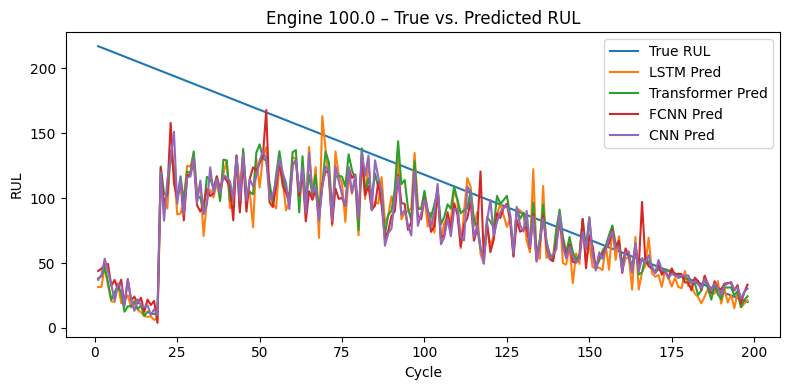

In [ ]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()